# Santa Catarina TFA inversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os

from fatiando import utils
from fatiando.vis import mpl
from fatiando.gravmag import polyprism

/home/leo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing TFA data

In [3]:
mypath = 'eqlayer_rs/direction_inc-37_dec-18_h-400m/eqlayer_depth-400m.pickle'

In [4]:
with open(mypath) as w:
        di = pickle.load(w)

In [5]:
xp = di['x']
yp = di['y']
zp = di['z']
dobs = di['upward']

### Parameters for inversion

In [6]:
# output of inversion
inversion = dict()

In [7]:
inversion['xp'] = xp
inversion['yp'] = yp
inversion['x'] = di['xp']
inversion['y'] = di['yp']
inversion['xt'] = di['xt']
inversion['yt'] = di['yt']
inversion['zp'] = zp
inversion['observed_data'] = dobs
N = xp.size

In [8]:
#initial estimate
M = 30 # number of vertices per prism
L = 8 # number of prismsinc-37_dec-18_r1000_int6_z0250_dz300/
P = L*(M+2) + 1 # number of parameters

#figura
incs = -37.05
decs = -18.17
intensity = 2.5
z0 = -1200.
dz = 900.
r = 1500.
x0 = 6921000.
y0 = 688000.

# main field
inc = -37.05
dec = -18.17

model0, m0 = mfun.initial_cylinder(M, L, x0,
        y0, z0, dz, r, inc, dec, incs, decs, intensity)

# predict data
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec)

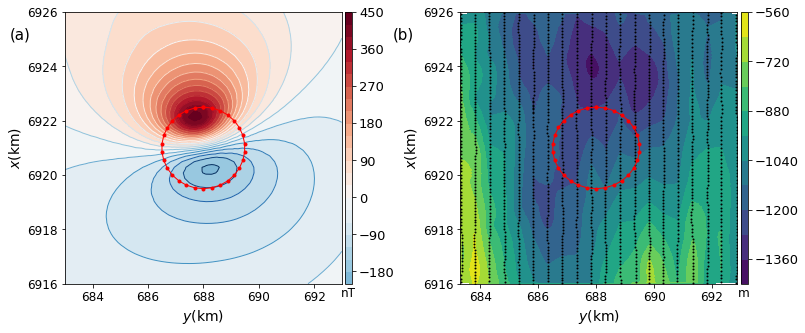

In [16]:
plt.figure(figsize=(13,5))

ax=plt.subplot(1,2,1)
plt.tricontour(yp, xp, dobs, 20, linewidths=1, cmap='RdBu_r')
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r',
               vmin=-np.max(dobs),
               vmax=np.max(dobs)).ax.tick_params(labelsize=12)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
plt.xlabel('$y$(km)', fontsize=14)
plt.ylabel('$x$(km)', fontsize=14)
clb = plt.colorbar(pad=0.01, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT', pad=-285)
ax.text(681000, 6925000, '(a)', fontsize= 15)
mpl.m2km()

ax=plt.subplot(1,2,2)
plt.tricontourf(di['yt'], di['xt'], di['topography'], 10, cmap='viridis').ax.tick_params(labelsize=12)
plt.plot(di['yt'], di['xt'], 'ko', markersize=1.)
plt.xlabel('$y$(km)', fontsize=14)
plt.ylabel('$x$(km)', fontsize=14)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
clb = plt.colorbar(pad=0.01, aspect=40, shrink=1)
clb.ax.set_title('m', pad=-285)
clb.ax.tick_params(labelsize=13)
ax.text(681000, 6925000, '(b)', fontsize= 15)
mpl.m2km()

plt.savefig(mypath+'data_alt.png', dpi=300, bbox_inches='tight')
plt.show()

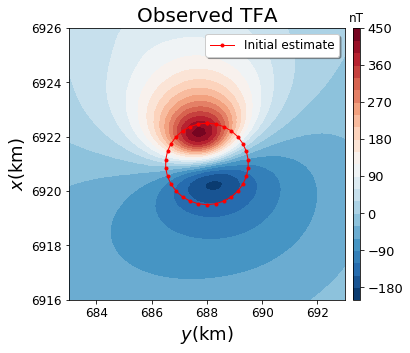

In [50]:
plt.figure(figsize=(6,5))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

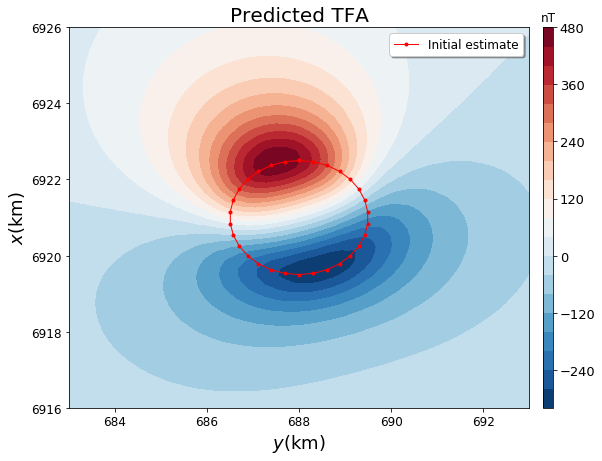

In [10]:
plt.figure(figsize=(10,7))
plt.title('Predicted TFA', fontsize=20)
plt.tricontourf(yp, xp, d0, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

In [11]:
# limits for parameters in meters
rmin = 100.
rmax = 3500.
y0min = 684000.
y0max = 693000.
x0min = 6918250.
x0max = 6926250.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

In [12]:
# variation for derivatives
deltax = 0.01*np.max(1000.)
deltay = 0.01*np.max(1000.)
deltar = 0.01*np.max(1000.)
deltaz = 0.01*np.max(1000.)
delta = np.array([deltax, deltay, deltar, deltaz])

In [13]:
m_out = np.zeros(M + 2)  # outcropping body parameters

### Regularization parameters

In [14]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-3  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-3     # vertically adjacent origins
a6 = 1.0e-6   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-5     # zero order Tikhonov on thickness of each prism

In [15]:
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [16]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

### Inversion

In [17]:
d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.levmarq_tf(xp, yp, zp, m0, M, L, delta, itmax,
                                                    itmax_marq, lamb, dlamb, tol,
                                                    mmin, mmax, m_out, dobs, inc, dec,
                                                    model0[0].props, alpha, z0, dz)

it:  0   it_marq:  0   lambda: 1e+01   init obj.: 1.38821e+03  fin obj.: 5.43138e+02
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 5.43138e+02  fin obj.: 1.40553e+02
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 1.40553e+02  fin obj.: 8.12412e+02
it:  2   it_marq:  1   lambda: 1e+00   init obj.: 1.40553e+02  fin obj.: 7.84798e+01
it:  3   it_marq:  0   lambda: 1e-01   init obj.: 7.84798e+01  fin obj.: 5.19551e+02
it:  3   it_marq:  1   lambda: 1e+00   init obj.: 7.84798e+01  fin obj.: 6.09536e+01
it:  4   it_marq:  0   lambda: 1e-01   init obj.: 6.09536e+01  fin obj.: 6.92217e+01
it:  4   it_marq:  1   lambda: 1e+00   init obj.: 6.09536e+01  fin obj.: 5.18400e+01
it:  5   it_marq:  0   lambda: 1e-01   init obj.: 5.18400e+01  fin obj.: 7.71813e+01
it:  5   it_marq:  1   lambda: 1e+00   init obj.: 5.18400e+01  fin obj.: 5.01436e+01
it:  6   it_marq:  0   lambda: 1e-01   init obj.: 5.01436e+01  fin obj.: 8.48643e+01
it:  6   it_marq:  1   lambda: 1e+00   init obj.: 5.01436e+01  fi

In [22]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['initial_estimate'] = model0
inversion['initial_data'] = d0
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = alpha
inversion['tol'] = tol
inversion['main_field'] = [inc, dec]
inversion['topography'] = -(di['zt'] - 100.)

In [51]:
mypath = 'up_tfa_inversion/V%d_L%d_inc%d_dec%d_r%d_int%d_z0%d_dz%d' % (M, L, incs, decs, r, intensity, z0, dz)
if not os.path.isdir(mypath):
   os.makedirs(mypath)

In [24]:
inversion['data_fit'] = d_fit
inversion['estimate'] = m_est
inversion['prisms'] = model_est
inversion['objective'] = phi_list
inversion['residual'] = dobs - d_fit

In [25]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)